<h1>Problem Set 7</h1> 
<h3><center>Quantitative Macro</center></h3>



<center>Pau Belda-i-Tortosa</center> |


<center>November 2018</center>


### GENERAL EQUILIBRIUM WITH $Z^H$

Repetition of previous exercise but for the good aggregate state, that is:

- $z= z^H= 1.05$
- $\Pi_g = [0.86, 0.14;0.1, 0.99]$

**ALGORITHM**
- Guess initial values for aggregate K,L.
- (K,L) gives us the equilibrium prices (r,k) given the parameter values and z. 
- Given (r,k) we solve the HH problem.
- With the asset function a'(a,e) we get the distribution of assets.
- Compute the invariant distribution. 
- Given the distribution and the asset policy, compute the aggregate K and L. 
- Update the guess until getting convergence. 

The aggregate (pc) assets are equal to 19.93
The aggregate equilibrium (pc) wealth  is equal to 18.65
The aggregate employment is equal to 0.43
The aggregate (pc) assets are equal to 21.56
The aggregate equilibrium (pc) wealth  is equal to 20.82
The aggregate employment is equal to 0.42
The aggregate (pc) assets are equal to 21.91
The aggregate equilibrium (pc) wealth  is equal to 21.22
The aggregate employment is equal to 0.42
The aggregate (pc) assets are equal to 21.98
The aggregate equilibrium (pc) wealth  is equal to 21.11
The aggregate employment is equal to 0.42


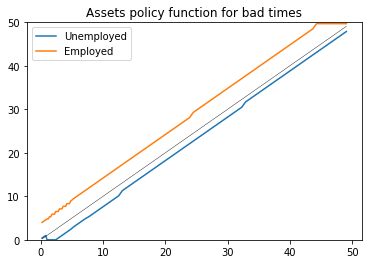

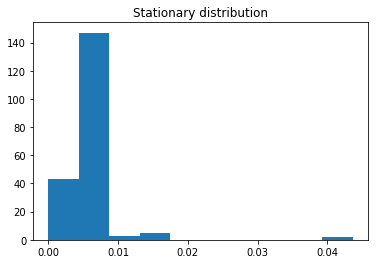

In [2]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.solvers.solveset import linsolve
import itertools as it
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.optimize import *
from numpy import *

#Parameters
Γ=2
γ=8
β=0.99

#State space
e=[0,1]
k0=np.arange(0,5,0.2)
k1=np.arange(5.3,50,0.6)
k=np.concatenate((k0,k1))
z=1.05
α=0.36

#Transition matrix
Π_g= [0.86, 0.14,0.1, 0.99]
Π_g=np.reshape(Π_g,[2,2])

#CONVERGENCE AGGREGATE K,L
#Initial guess
L=0.96
K= 17

eps=0.001
count=0
diffK=1
diffL=1
while diffK>eps and diffL>eps:

    #STEP 0: Endogenous Prices
    w=(1-α)*z*pow((K/L),α)
    r=α*z*pow((L/K),(1-α))

    #STEP 1: Computing the utility function for all possible combinations of assets today and tomorrow
    #Retrieving the Consumption Matrix using a non-linear solver
    C=np.empty((100,100,2))
    for i,I,j in it.product(range(100), range(100),range(2)):
        def Implicit(x):
            e=[0,1]
            k=np.concatenate((k0,k1))
            c=x[0]
            F=empty((1))
            F[0] = pow(w*e[j], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*k[i] - k[I] -c
            return F
        C[i,I,j]=fsolve(Implicit,1)

    #Utility for consumption 
    logC= np.log(C)
    #Computing disutility from labour
    U_L = (Γ/(1+γ))*pow((w/Γ*C), (1+γ)/γ)
    #Total Utility 
    U= logC - U_L

    #STEP 2: Initial Guess 
    #Define initial functions 
    V0b=np.zeros((100,1))
    V1b=np.zeros((100,1))
    G0b=np.zeros((100,1))
    G1b=np.zeros((100,1))


    #STEP 3: Value Function Iteration
    V0bt=np.zeros((100,1))
    V1bt=np.zeros((100,1))

    count = 0
    eps=0.001
    Devb=0.5
    while Devb > eps: 
        for i in range(99):
            V0bt[i]= max(U[i,:,0] + β*((Π_g[0,0]*V0b[i])+ (Π_g[0,1]*V1b[i])))       
            V1bt[i] = max(U[i,:,1] + β*((Π_g[1,0]*V0b[i])+(Π_g[1,1]*V1b[i])))
            G0b[i] = np.argmax(U[i,:,0] + β*((Π_g[0,0]*V0b[i])+ (Π_g[0,1]*V1b[i])))
            G1b[i] = np.argmax(U[i,:,1] + β*((Π_g[1,0]*V0b[i])+(Π_g[1,1]*V1b[i])))

        #Check the difference
        Diff0b=abs(V0bt-V0b)
        dev0b=Diff0b.max()
        Diff1b=abs(V1bt-V1b)
        dev1b=Diff1b.max()
        Devb=max(dev0b, dev1b)
       
        #Update
        V0b=V0bt
        V1b=V1bt 
        count+=1

    #STEP 4: Policy functions
    g0b=np.zeros((100,1))
    g1b=np.zeros((100,1))

    for i in range(100):
        g0b[i]=k[int(G0b[i])]
        g1b[i]=k[int(G1b[i])]

    
    #STEP 5: Aggregation. We have 200 different social positions. 
    assets=np.vstack((g0b,g1b))
    A=sum(assets)/200
    print('The aggregate (pc) assets are equal to '"{0:.2f}".format(A))


    #STEP 6: INVARIANT DISTRIBUTION
    #Measure over assets
    #Matrix I: assets transition
    k=np.concatenate((k0,k1))
    grid=np.hstack((k,k))
    I=np.empty((200,200))
    for i in range(200):
        for j in range(200):
            I[i,j]= int(grid[i] ==assets[j])

    #Matrix Pi: employment transition
    π00=np.ones(100)*0.79
    π01=np.ones(100)*0.21
    π10=np.ones(100)*0.03
    π11=np.ones(100)*0.97

    π0=np.transpose(np.concatenate((π00,π01), axis=0))
    π1=np.transpose(np.concatenate((π10,π11), axis=0))
    π0=np.tile(π0,(100,1))
    π1=np.tile(π1,(100,1))
    π=np.vstack((π0,π1))

    #Matrix T: state transition
    T=np.multiply(π,I)

    #Vector M: distribution guess
    M=np.ones((200,1))*(1/200)

    #Invariant distribution
    eps=0.001
    diff=1
    count=0
    while diff>eps:
        Distribution=T@M
        diff=(Distribution-M).all()
        count+=1
        M=Distribution

    np.sum(Distribution)

    #Aggregate savings
    S=Distribution*assets
    print('The aggregate equilibrium (pc) wealth  is equal to '"{0:.2f}".format(np.sum(S)))

    #STEP 7: Aggregate labour
    S0=S[0:100]
    S1=S[100:200]
    #First, recover the optimal consumption vector
    C1b=np.empty((100,1))
    C0b=np.empty((100,1))
    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = pow(w, (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*S1[i] - S1[I] -c
            return F

        C1b[i]=fsolve(Ramsey,1)

    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = (1+r)*S0[i] - S0[I] -c
            return F

        C0b[i]=fsolve(Ramsey,1)

    #Recover the optimal labour vector
    N0b=np.zeros((100,1))
    N1b=np.empty((100,1))
    for j in range(100):
        N1b[j] = pow(((w*e[1])/(Γ*C1b[j])), 1/γ)

    E=np.concatenate((N0b,N1b))
    Employment=Distribution*E
    print('The aggregate employment is equal to '"{0:.2f}".format(np.sum(Employment)))
    
    #STEP 8: Check & update
    #Check the difference
    diffK=abs(np.sum(S)-K)
    diffL=abs(np.sum(Employment)-L)
    
    #Update the guess
    count+=1
    L=np.sum(Employment)
    K=np.sum(S)

#PLOT THE FINAL POLICY AND DISTRIBUTION
plt.plot(k[1:99],g0b[1:99], label='Unemployed')
plt.plot(k[1:99],g1b[1:99], label='Employed')
plt.plot(k[1:99],k[1:99], 'k', linewidth=0.4)
plt.legend()
plt.ylim([0,50])
plt.title('Assets policy function for bad times')
plt.show()      


plt.hist(Distribution)
plt.title('Stationary distribution')
plt.show()